In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle

from statsmodels.tsa.vector_ar.var_model import VAR

import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# Data

In [2]:
df = pd.read_csv('DATAA.csv', parse_dates=[['Date', 'Time']])
df['Date_Time'] = pd.to_datetime(df.Date_Time , format = '%d/%m/%Y %H.%M.%S')
# Sort on time
df = df.sort_values(by='Date_Time')

df.head()

,Date_Time,No of Vehicles,Wind Speed,Visibility,Accident,Unnamed: 6,WS,Unnamed: 8,V,Unnamed: 10,A
23,2022-10-01 00:00:00,4523,17,16.0,3,-0.39542,-3954.2,2.4432,2443.2,-0.08643,-864.3
0,2022-10-01 01:00:00,3434,6,16.0,3,-0.13956,-1395.6,2.4432,2443.2,-0.08643,-864.3
1,2022-10-01 02:00:00,2229,7,16.0,5,-0.16282,-1628.2,2.4432,2443.2,-0.14405,-1440.5
2,2022-10-01 03:00:00,1583,19,16.0,4,-0.44194,-4419.4,2.4432,2443.2,-0.11524,-1152.4
3,2022-10-01 04:00:00,1360,15,16.0,3,-0.34890,-3489.0,2.4432,2443.2,-0.08643,-864.3


In [3]:
# Drop unnamed column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Drop wind speed, visibility, and accident
df = df.drop(['Wind Speed', 'Visibility', 'Accident'], axis=1)

# Only visibility will be here so drop the rest
df = df.drop(['WS', 'A'], axis=1)

df.head()

,Date_Time,No of Vehicles,V
23,2022-10-01 00:00:00,4523,2443.2
0,2022-10-01 01:00:00,3434,2443.2
1,2022-10-01 02:00:00,2229,2443.2
2,2022-10-01 03:00:00,1583,2443.2
3,2022-10-01 04:00:00,1360,2443.2


In [4]:
# Plot correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

/tmp/ipykernel_7942/3037099363.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,No of Vehicles,V
No of Vehicles,1.000000,0.152720
V,0.152720,1.000000


<AxesSubplot: xlabel='Date_Time'>

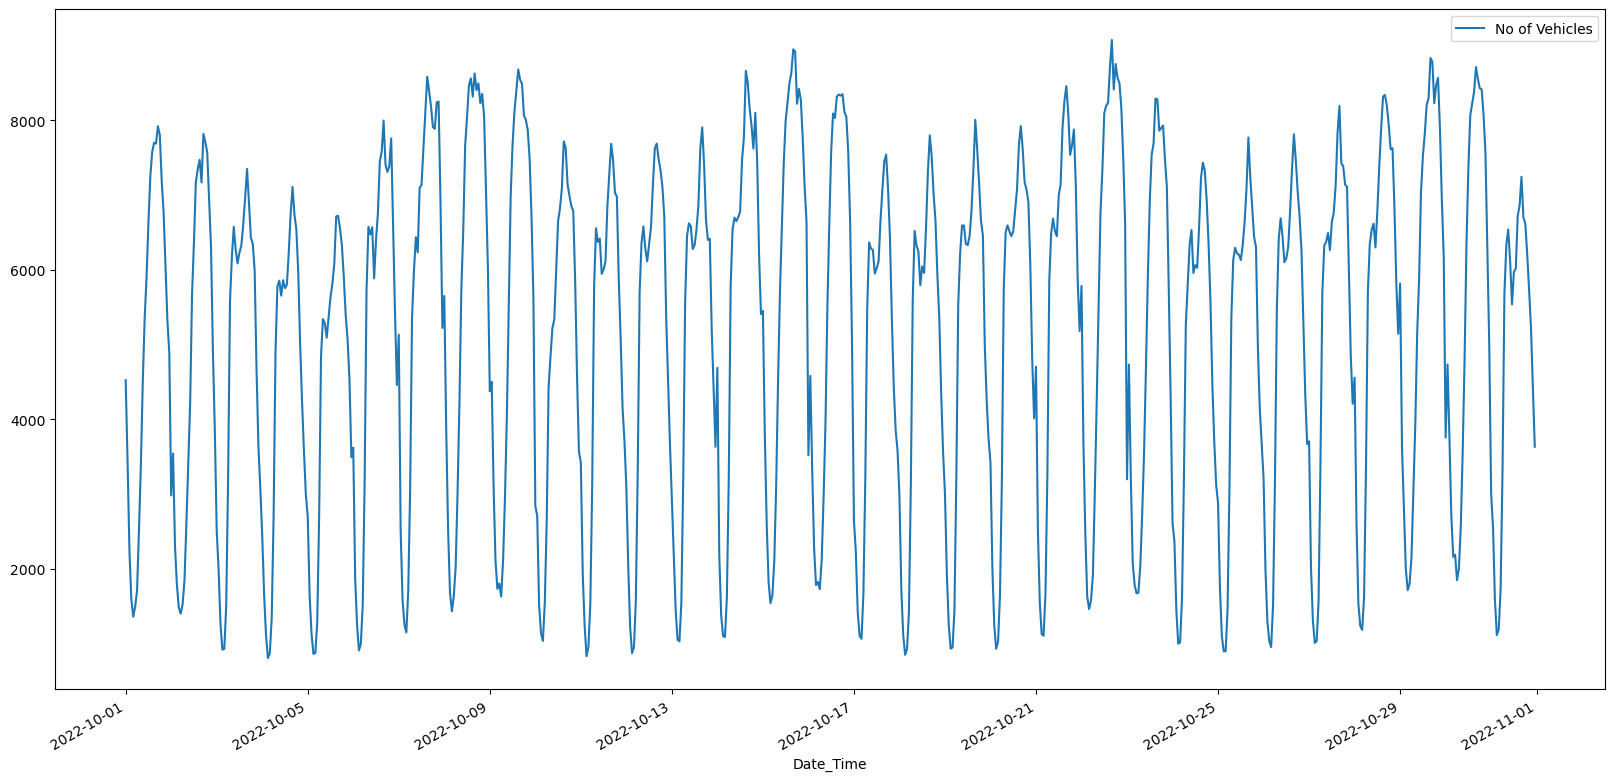

In [5]:
# Plot the data
df.plot(x='Date_Time', y=['No of Vehicles'], figsize=(20,10))

In [6]:
# Check if data is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['No of Vehicles'].values)
print('ADF Statistic: %f' % result[1])

ADF Statistic: 0.005820


/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


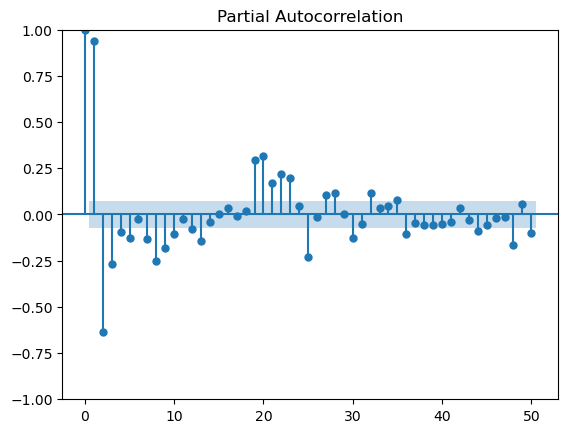

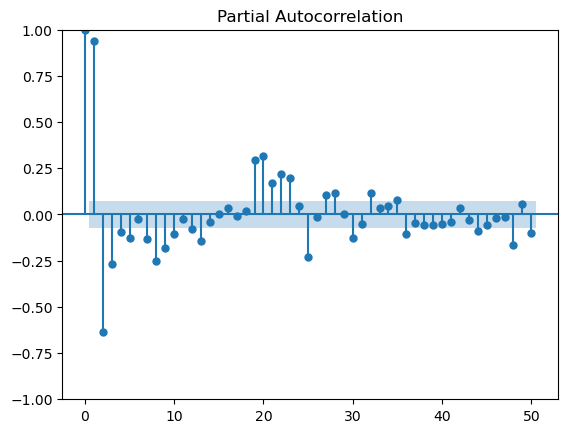

In [7]:
# Partial Autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df['No of Vehicles'].values, lags=50)

The stationary test returns p value less than 0.05, so it is stationary and no transformation is needed

The partial autocorrelation shows that 1-5, 7-10, 25, 30 and so on lags can be used.

# Split data

In [8]:
data = df.drop(['Date_Time'], axis=1)
data.index = df.Date_Time

#creating the train and validation set for VAR model
train = data[:int(0.8*(len(data)))]
valid = data[int(0.8*(len(data))):]

In [9]:
# Create dataframes for train and valid for multivariate regression
X = data.drop(['No of Vehicles'], axis=1)
y = data['No of Vehicles']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((595, 1), (149, 1), (595,), (149,))

In [10]:
# Add lags to the data
for i in range(1,25):
    df["lag_{}".format(i)] = df['No of Vehicles'].shift(i)
    
# Create train and test set from lagged data
df.dropna(inplace=True)
X = df.drop(['No of Vehicles', 'Date_Time'], axis=1)
y = df['No of Vehicles']

X_train_lagged, X_test_lagged, y_train_lagged, y_test_lagged = train_test_split(X, y, test_size=0.2, shuffle=False)

# VAR Model

In [11]:
forecasting_model = VAR(train)

/mnt/A6E6E098E6E069CF/L4T2/Extra/ML/Notebook/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
results_aic = []

for p in range(1,50):
    results = forecasting_model.fit(p)
    results_aic.append(results.aic)

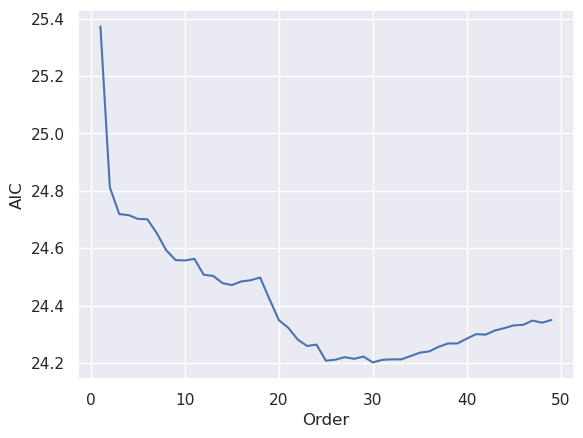

In [13]:
sns.set()
plt.plot(list(np.arange(1,50,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [14]:
# Lowest AIC is 25, which matches the PACF plot
results = forecasting_model.fit(25)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, May, 2023
Time:                     21:10:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    24.9854
Nobs:                     570.000    HQIC:                   24.5111
Log likelihood:          -8414.79    FPE:                3.26363e+10
AIC:                      24.2077    Det(Omega_mle):     2.74959e+10
--------------------------------------------------------------------
Results for equation No of Vehicles
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                    571.902644       241.754757            2.366           0.018
L1.No of Vehicles          0.961181         0.042711           22.504           0.000
L1.V                      -0.11

In [15]:
laaged_values = train.values[-25:]

forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=len(valid)), index = valid.index, columns=valid.columns + '_1d')
forecast.head()

,No of Vehicles_1d,V_1d
Date_Time,,
2022-10-25 18:59:59,6152.208778,1845.091686
2022-10-25 20:00:00,5518.874776,1851.387221
2022-10-25 21:00:00,4553.722628,1791.689119
2022-10-25 21:59:59,3722.818477,1868.025781
2022-10-25 23:00:00,3185.423971,1935.996231


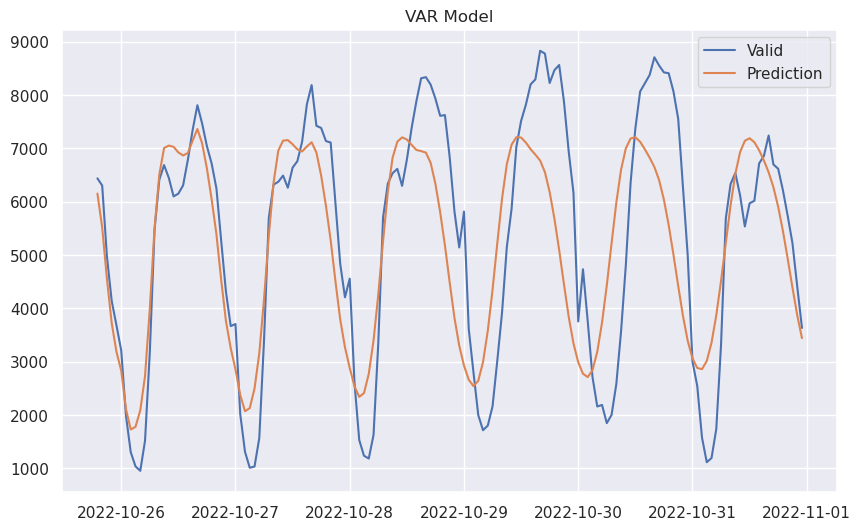

In [16]:
# Plotting the results and actual values
plt.figure(figsize=(10,6))
plt.plot(valid['No of Vehicles'], label='Valid')
plt.plot(forecast['No of Vehicles_1d'], label='Prediction')
plt.legend(loc='best')
plt.title("VAR Model")
plt.show()

In [17]:
# Calculate RMSE
rms = np.sqrt(mean_squared_error(valid['No of Vehicles'].values, forecast['No of Vehicles_1d'].values))
print("RMSE: ", rms)

RMSE:  1440.0830461270716


# Random Forest Regression

In [18]:
rf = RandomForestRegressor()

rf.fit(X_train_lagged, y_train_lagged)
pred_rf = rf.predict(X_test_lagged)

# Calculate RMSE
print(np.sqrt(mean_squared_error(pred_rf, y_test_lagged)))

329.20144022969515


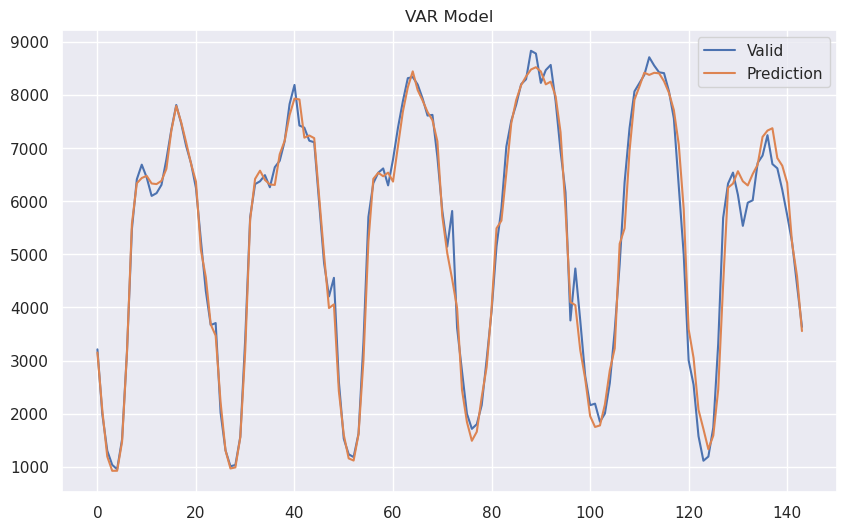

In [19]:
# Plotting the results and actual values
plt.figure(figsize=(10,6))
plt.plot(y_test_lagged.values, label='Valid')
plt.plot(pred_rf, label='Prediction')
plt.legend(loc='best')
plt.title("VAR Model")
plt.show()

# Adaboost Regression

In [20]:
adaboost = AdaBoostRegressor()

adaboost.fit(X_train_lagged, y_train_lagged)
pred_adaboost = adaboost.predict(X_test_lagged)

# Calculate RMSE
print(np.sqrt(mean_squared_error(pred_adaboost, y_test_lagged)))

468.63059524181546


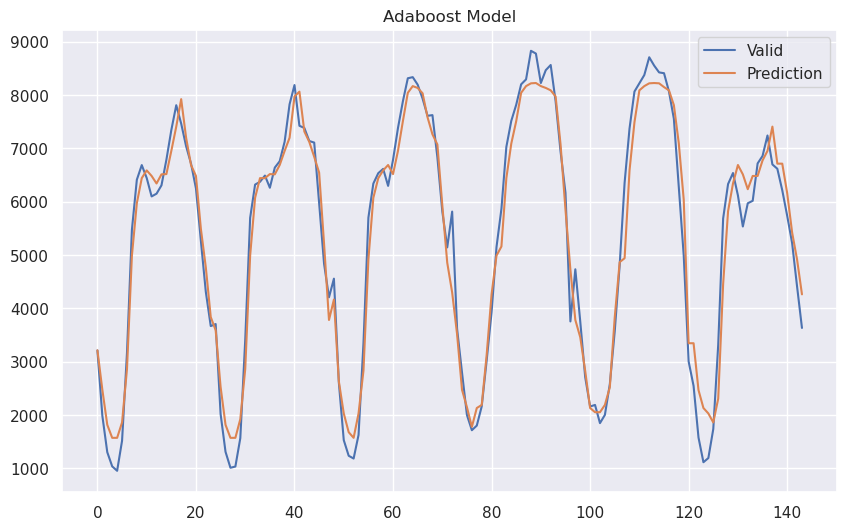

In [21]:
# Plotting the results and actual values
plt.figure(figsize=(10,6))
plt.plot(y_test_lagged.values, label='Valid')
plt.plot(pred_adaboost, label='Prediction')
plt.legend(loc='best')
plt.title("Adaboost Model")
plt.show()

# XGBoost Model

In [22]:
xgboost = xgb.XGBRegressor()

xgboost.fit(X_train_lagged, y_train_lagged)
pred_xgboost = xgboost.predict(X_test_lagged)

# Calculate RMSE
print(np.sqrt(mean_squared_error(pred_xgboost, y_test_lagged)))

300.2593521634229


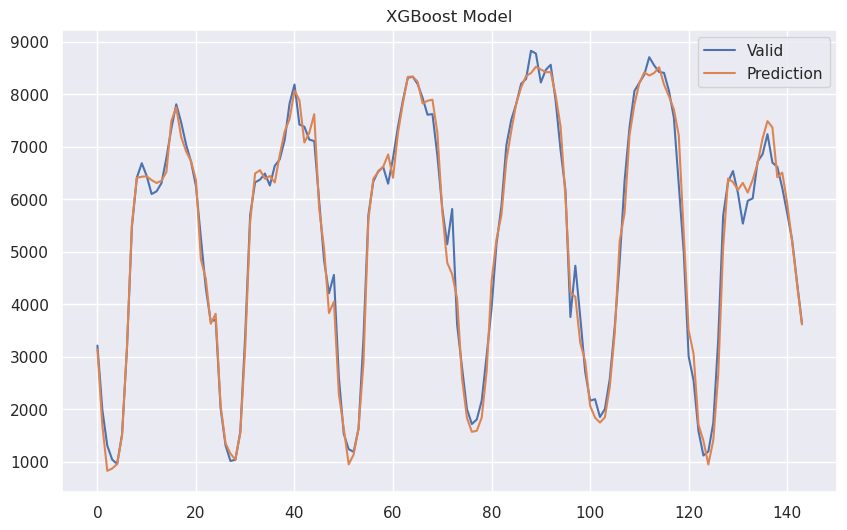

In [23]:
# Plotting the results and actual values
plt.figure(figsize=(10,6))
plt.plot(y_test_lagged.values, label='Valid')
plt.plot(pred_xgboost, label='Prediction')
plt.legend(loc='best')
plt.title("XGBoost Model")
plt.show()

# Save all the models

In [24]:
# Save VAR model
pickle.dump(results, open('VAR_Vis.pkl', 'wb'))

In [25]:
# Save XGBoost model
pickle.dump(xgboost, open('XGBoost_Vis.pkl', 'wb'))

In [26]:
# Save Adaboost model
pickle.dump(adaboost, open('Adaboost_Vis.pkl', 'wb'))

In [27]:
# Save Random Forest model
pickle.dump(rf, open('RandomForest_Vis.pkl', 'wb'))